Time Series Forecasting using LSTM on Delhi Climate Dataset Used from Kaggle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

LOADING THE DATASET

In [ ]:
data_train = pd.read_csv('/content/DailyDelhiClimateTrain.csv')
data_test = pd.read_csv('/content/DailyDelhiClimateTest.csv')

VISUALIZING THE DATASET

<Axes: >

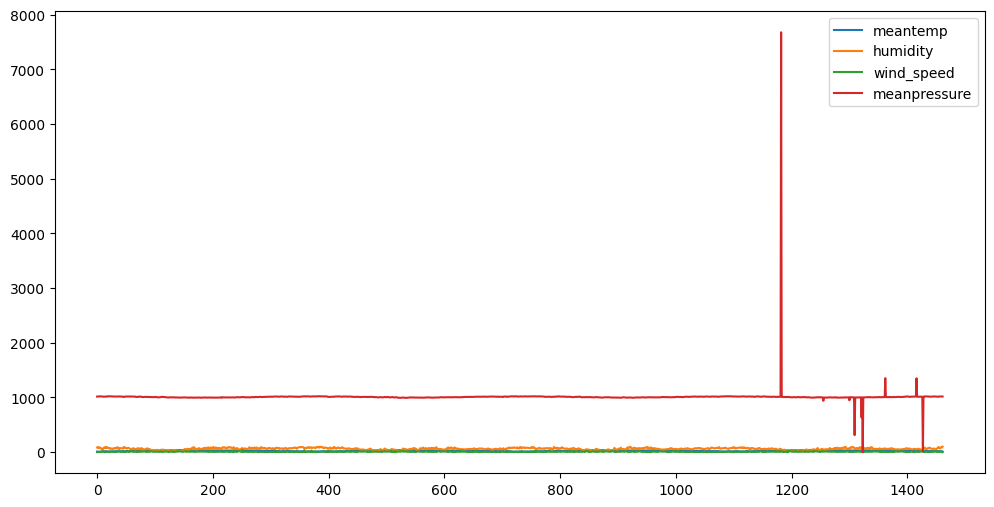

In [ ]:
data_train.head()
data_train.shape
data_train.plot(figsize=(12,6))

<Axes: >

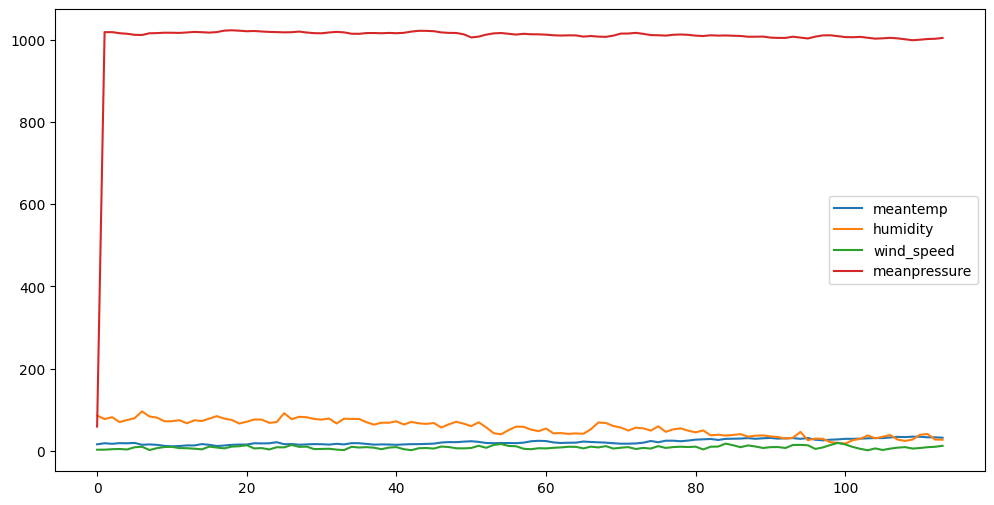

In [ ]:
data_test.head()
data_test.shape
data_test.plot(figsize=(12,6))

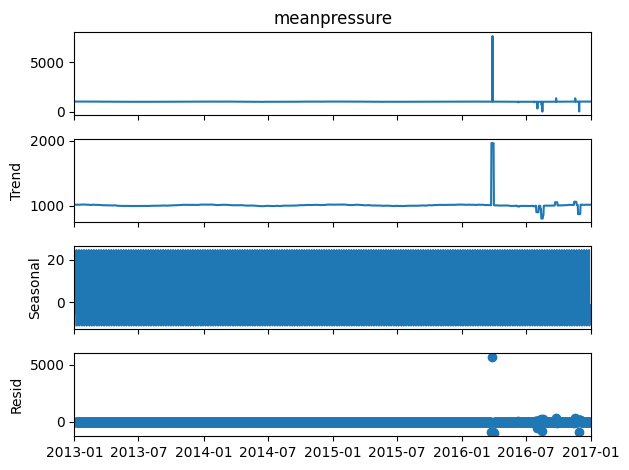

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the 'date' column is a datetime object
data_train['date'] = pd.to_datetime(data_train['date'])

# Set the 'date' column as the index
data_train.set_index('date', inplace=True)

# Check if the data is daily. If not, set a frequency
data_train = data_train.asfreq('D')  # Ensure daily frequency

# Perform seasonal decomposition
results = seasonal_decompose(data_train['meanpressure'], model='additive')

# Plot the decomposition
results.plot();


In [ ]:
data_train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
data_train.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [ ]:
#look for null values
data_train.isnull().sum()

,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


VERIFYING OUTLIERS

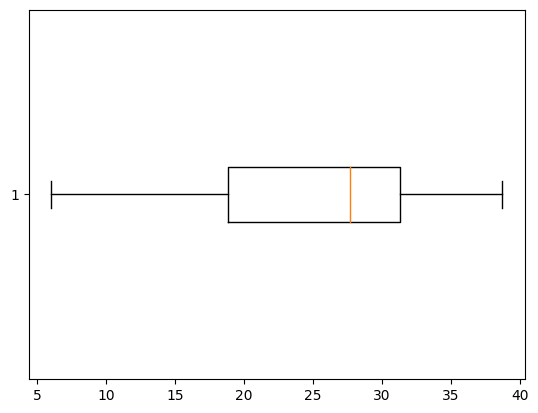

In [ ]:
plt.boxplot(data_train['meantemp'], vert=False)
plt.show()

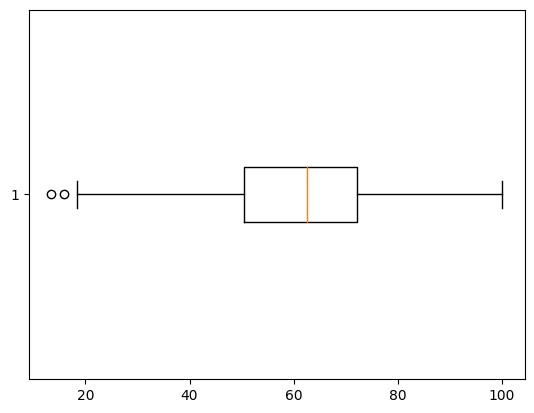

In [ ]:
plt.boxplot(data_train['humidity'], vert=False)
plt.show()

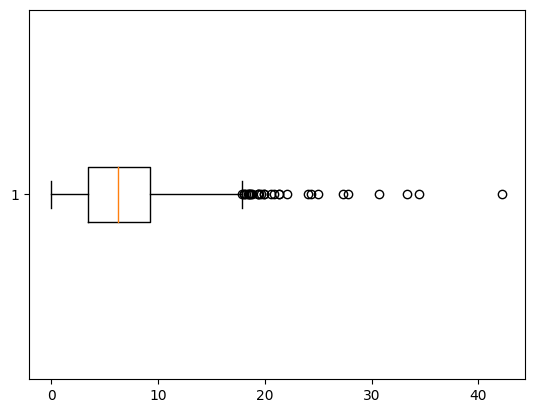

In [ ]:
plt.boxplot(data_train['wind_speed'], vert=False)
plt.show()

In [ ]:
data_train['wind_speed'].describe()

,wind_speed
count,1462.000000
mean,6.802209
std,4.561602
min,0.000000
25%,3.475000
50%,6.221667
75%,9.238235
max,42.220000


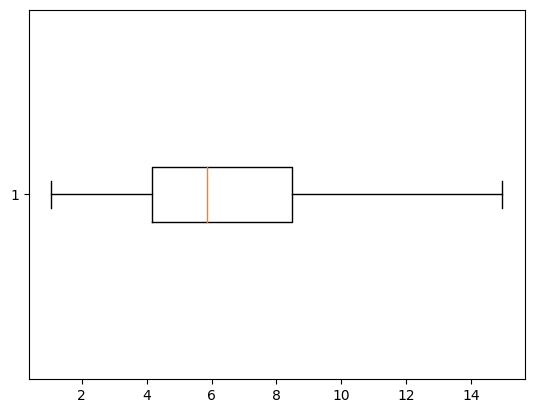

In [ ]:
median = data_train.loc[data_train['wind_speed']<15, 'wind_speed'].median()
data_train.loc[data_train['wind_speed'] < 1, 'wind_speed'] = np.nan
data_train.loc[data_train['wind_speed'] > 15, 'wind_speed'] = np.nan
data_train['wind_speed'].fillna(median,inplace=True)

plt.boxplot(data_train['wind_speed'], vert=False)
plt.show()

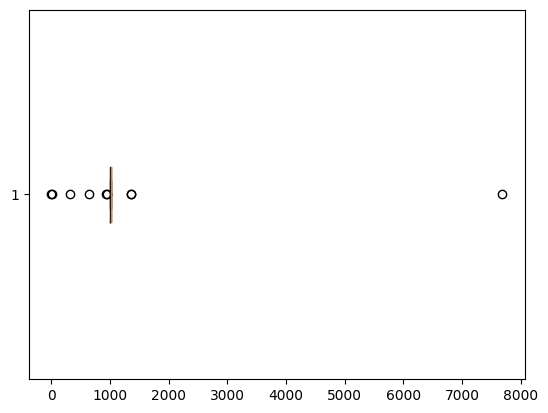

,meanpressure
count,1462.000000
mean,1011.104548
std,180.231668
min,-3.041667
25%,1001.580357
50%,1008.563492
75%,1014.944901
max,7679.333333


In [ ]:
plt.boxplot(data_train['meanpressure'], vert=False)
plt.show()

data_train['meanpressure'].describe()

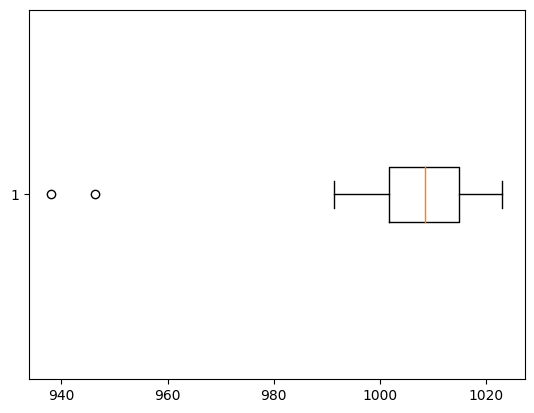

In [ ]:
median1 = data_train.loc[data_train['meanpressure']<1050, 'meanpressure'].median()
data_train.loc[data_train['meanpressure'] > 1050 , 'meanpressure'] = np.nan #atmospheric pressure usually lies between 760 and 1050 atm
data_train.loc[data_train['meanpressure'] < 760 , 'meanpressure'] = np.nan
data_train['meanpressure'].fillna(median1,inplace=True)

plt.boxplot(data_train['meanpressure'], vert=False)
plt.show()

STANDARDISING

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler2=MinMaxScaler()
scaler3=MinMaxScaler()
scaler4=MinMaxScaler()

meantemp_scaled = scaler.fit_transform(data_train[['meantemp']])
humidity_scaled = scaler2.fit_transform(data_train[['humidity']])
windspeed_scaled = scaler3.fit_transform(data_train[['wind_speed']])
meanpressure_scaled = scaler4.fit_transform(data_train[['meanpressure']])

In [ ]:
#Combining all scaled columns
X_scaled = np.concatenate((meantemp_scaled, humidity_scaled, windspeed_scaled, meanpressure_scaled), axis=1)
X_scaled.shape

(1462, 4)

CREATING TRAINING BATCHES

In [ ]:
x=[]
for i in range(X_scaled.shape[0]-30):
    row = X_scaled[i:i+31]
    x.append(row)

x=np.array(x)
X_train = x[:,:-1] #1st 30 values will be considered as x values
Y_train = x[:,-1,0] #last value will be considered as our y value
X_train.shape ,Y_train.shape, X_train.ndim, Y_train.ndim

X_train = X_train.reshape(-1,4,30)

SIMULATING THE LSTM MODEL

In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))  # LSTM forward pass
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last time step's output
        return out


In [ ]:
# Where sequence_length = 30 and num_features = 4
X_train = X_train.transpose(0, 2, 1)  # Shape becomes (batch_size, 30, 4)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

# DataLoader for batching
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


In [ ]:
# Define model parameters
input_size = 4  # Number of input features (meantemp, humidity, wind_speed, meanpressure)
hidden_size = 50  # Number of units in the hidden layer
output_size = 1  # Predicting one value (meantemp)
num_layers = 1  # Number of LSTM layers

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Training loop
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Optionally: You can add validation code here using a similar loop

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train Loss: 0.1790
Epoch 2/20, Train Loss: 0.0485
Epoch 3/20, Train Loss: 0.0486
Epoch 4/20, Train Loss: 0.0487
Epoch 5/20, Train Loss: 0.0482
Epoch 6/20, Train Loss: 0.0479
Epoch 7/20, Train Loss: 0.0486
Epoch 8/20, Train Loss: 0.0484
Epoch 9/20, Train Loss: 0.0488
Epoch 10/20, Train Loss: 0.0483
Epoch 11/20, Train Loss: 0.0479
Epoch 12/20, Train Loss: 0.0481
Epoch 13/20, Train Loss: 0.0482
Epoch 14/20, Train Loss: 0.0484
Epoch 15/20, Train Loss: 0.0479
Epoch 16/20, Train Loss: 0.0482
Epoch 17/20, Train Loss: 0.0490
Epoch 18/20, Train Loss: 0.0481
Epoch 19/20, Train Loss: 0.0483
Epoch 20/20, Train Loss: 0.0481


NOW TESTING THE DATA

In [ ]:
#creating new dataframe which will have the last 30 rows of training data and the entire test data
new_data = pd.DataFrame()
new_data = pd.concat([data_train.tail(30), data_test], ignore_index=True)
new_data = new_data.drop(columns=['date'])


In [ ]:
new_data.head()

,meantemp,humidity,wind_speed,meanpressure
0,21.208333,52.166667,5.866667,1019.333333
1,18.900000,55.250000,5.666667,1019.700000
2,18.636364,56.590909,4.952381,1017.045455
3,18.538462,69.923077,2.503846,1017.961538
4,18.250000,74.350000,5.870833,1017.421053


In [ ]:
new_data.shape

(144, 4)

STANDARDISING TEST DATA

In [ ]:
meantemp_scaled1 = scaler.fit_transform(new_data[['meantemp']])
humidity_scaled1 = scaler2.fit_transform(new_data[['humidity']])
windspeed_scaled1 = scaler3.fit_transform(new_data[['wind_speed']])
meanpressure_scaled1 = scaler4.fit_transform(new_data[['meanpressure']])

new_data_scaled = np.concatenate((meantemp_scaled1, humidity_scaled1, windspeed_scaled1, meanpressure_scaled1), axis=1)


CREATING BATCHES

In [ ]:
x1=[]
for i in range(new_data_scaled.shape[0]-30):
    row = new_data_scaled[i:i+31]
    x1.append(row)

x1=np.array(x1)
X_test = x1[:,:-1]
Y_test = x1[:,-1,0]
X_test.shape ,Y_test.shape, X_test.ndim, Y_test.ndim

((114, 30, 4), (114,), 3, 1)

In [ ]:
X_test = X_test.reshape(-1,4,30)

MAKING PREDICITIONS

In [ ]:
# Reshape X_test correctly for PyTorch model
X_test = X_test.transpose(0, 2, 1)  # Shape becomes (batch_size, 30, 4)

# Convert to PyTorch tensor
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

# Set model to evaluation mode
model.eval()

# Get predictions
with torch.no_grad():  # Disable gradient calculation for inference
    predictions = model(X_test).cpu().numpy()  # Move the predictions back to CPU and convert to NumPy array

# Inverse transform the predictions to the original scale
predictions = scaler.inverse_transform(predictions)

# Reshape Y_test for inverse transform
Y_test = Y_test.reshape(-1, 1)  # Convert Y_test to same shape as predictions
Y_test = scaler.inverse_transform(Y_test)


VISUALIZING THE RESULTS

In [ ]:
#first 10 actual values
Y_test[:10]


array([[15.91304348],
       [18.5       ],
       [17.11111111],
       [18.7       ],
       [18.38888889],
       [19.31818182],
       [14.70833333],
       [15.68421053],
       [14.57142857],
       [12.11111111]])

In [ ]:
#first 10 predicted values
predictions[:10]


array([[24.933739],
       [23.508509],
       [24.697435],
       [24.75834 ],
       [24.732374],
       [24.777115],
       [24.971197],
       [25.158876],
       [24.951086],
       [24.669327]], dtype=float32)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Mean Absolute Error
mae = mean_absolute_error(Y_test, predictions)
print(f'Mean Absolute Error: {mae}')

# Root Mean Square Error
mse = mean_squared_error(Y_test, predictions)
rmse = np.sqrt(mse)
print(f'Root Mean Square Error: {rmse}')


Mean Absolute Error: 6.3115459289000455
Root Mean Square Error: 7.048130093529101


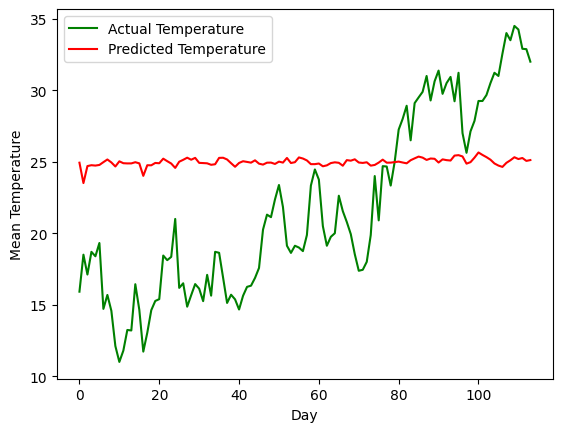

In [ ]:
plt.plot(Y_test, label='Actual Temperature', color='green')
plt.plot(predictions, label='Predicted Temperature', color='red')
plt.legend(loc='best')
plt.xlabel('Day')
plt.ylabel('Mean Temperature')
plt.show()

In [ ]:
#Coefficient of Determination
# r2_score = r2_score(Y_test, predictions)
# r2_score